In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report, matthews_corrcoef
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name, file_name):
    #  load data
    data = pd.read_csv('{}{}.csv'.format(dir_name,file_name), encoding = 'latin-1', usecols=['Message_body', 'Label'])
    data = data.rename(columns={'Label': 'label', 'Message_body': 'text'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

raw_train_data = get_raw_data(dir_name + 'datasets/email_spam/', 'train')
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


In [ ]:
raw_train_data['text'].is_unique

False

In [ ]:
raw_train_data.drop_duplicates(subset=['text'], inplace=True)
raw_train_data['text'].is_unique

True

In [ ]:
raw_train_data

,text,label
0,Rofl. Its true to its name,0
1,The guy did some bitching but I acted like i'd...,0
2,"Pity, * was in mood for that. So...any other s...",0
3,Will ü b going to esplanade fr home?,0
4,This is the 2nd time we have tried 2 contact u...,1
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


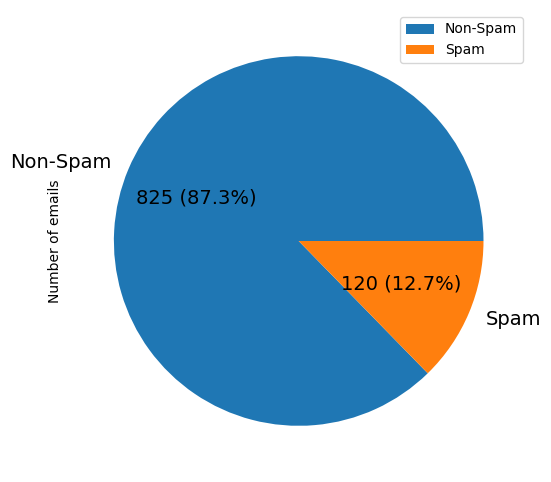

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of emails': [data['label'].value_counts()[0], data['label'].value_counts()[1]]}
    df = pd.DataFrame(dataset_statistics, index=['Non-Spam', 'Spam'])
    df.plot(kind='pie', y='Number of emails', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
# Raw data statistics
get_dataset_statistics(raw_train_data)

In [ ]:
raw_test_data = get_raw_data(dir_name + 'datasets/email_spam/', 'test')
raw_test_data

,text,label
0,"UpgrdCentre Orange customer, you may now claim...",1
1,"Loan for any purpose £500 - £75,000. Homeowner...",1
2,Congrats! Nokia 3650 video camera phone is you...,1
3,URGENT! Your Mobile number has been awarded wi...,1
4,Someone has contacted our dating service and e...,1
...,...,...
120,7 wonders in My WORLD 7th You 6th Ur style 5th...,0
121,Try to do something dear. You read something f...,0
122,Sun ah... Thk mayb can if dun have anythin on....,0
123,"SYMPTOMS when U are in love: ""1.U like listeni...",0


In [ ]:
raw_test_data['label'].value_counts()

1    76
0    49
Name: label, dtype: int64

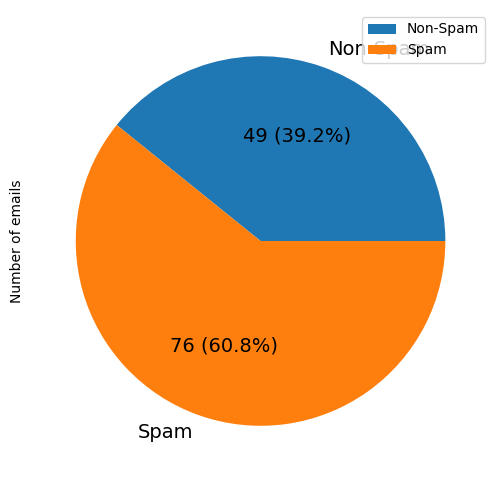

In [ ]:
get_dataset_statistics(raw_test_data)

# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def message_preprocessing(raw_message):
  message_words = raw_message.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(message_words.lower())
  filtered_message = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_message)

In [ ]:
train_data = raw_train_data[['text', 'label']].copy()

train_data['text'] = raw_train_data['text'].apply(message_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,rofl true,0
1,guy bitching acted like id interested buying w...,0
2,pity mood soany suggestions,0
3,ü b going esplanade fr home,0
4,2nd time tried 2 contact u u £750 pound prize ...,1
...,...,...
952,hows favourite person today r u workin hard sl...,0
953,got cleaning,0
954,sorry da gone mad pending works,0
955,wat time ü finish,0


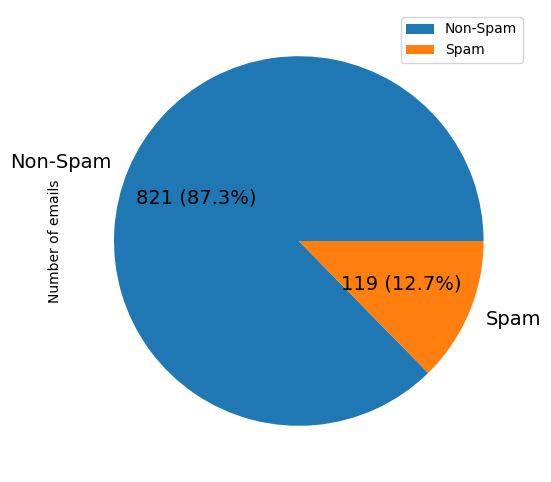

In [ ]:
get_dataset_statistics(train_data)

In [ ]:
test_data = raw_test_data[['text', 'label']].copy()

test_data['text'] = raw_test_data['text'].apply(message_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,upgrdcentre orange customer claim free camera ...,1
1,loan purpose £500 £75000 homeowners tenants we...,1
2,congrats nokia 3650 video camera phone 0906638...,1
3,urgent mobile number awarded £2000 prize guara...,1
4,contacted dating service entered phone fancy l...,1
...,...,...
120,7 wonders world 7th 6th ur style 5th ur smile ...,0
121,try dear read exams,0
122,sun ah thk mayb dun anythin thk book e lesson ...,0
123,symptoms u love 1u like listening songs 2u sto...,0


# Text Representation

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(sms_text) for sms_text in test_data['text'].values]))

In [ ]:
X_test.shape

(124, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(124,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='binary')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score', 'MCC'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0],
      results['split{}_test_MCC'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Email Spam/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score),
                                                                       'Precision': make_scorer(precision_score),
                                                                       'MCC' : make_scorer(matthews_corrcoef)
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    f1score = f1_score(test_labels, y_pred)
    f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
    mcc = matthews_corrcoef(y_test, y_pred)

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print("MCC = {}".format(mcc))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score
    evaluation_metrics.loc[model_name, 'MCC'] = mcc

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [5,10,15,20,25], 'max_features': [10, 15, 20], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [5,6,7]}]
        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf', 'poly'], 'degree': [2, 3 ,4, 5] }]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score', 'MCC'])

# Text Augmentation

In [ ]:
all_similar_words = {}

In [ ]:
def get_similar_words(word, similarity_threshold = 0.6):
  if word not in all_similar_words:
    similar_words = []
    for w, sim in word2vec_model.most_similar(positive=[word]):
      if sim >= similarity_threshold:
        similar_words.append(w)
    all_similar_words[word] = list(set(similar_words))
  return all_similar_words[word]

In [ ]:
from numpy.linalg import norm
 
def cos_sim(v1, v2):
  return np.dot(v1, v2)/(norm(v1)*norm(v2))

In [ ]:
def get_sentence_augmentations(sentence, word_sim_threshold=.6, sent_sim_threshold=.65):
  sent_vec = get_text_vec(sentence)
  sentence_tokens = word_tokenize(sentence.lower())
  pos_tags = dict(pos_tag(sentence_tokens))
  new_sentences = []
  for word in sentence_tokens:
    if word in word2vec_model.key_to_index and pos_tags[word] in ['NN', 'NNS', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']:
      similar_words = get_similar_words(word, word_sim_threshold)
      if len(similar_words) > 0:
        for similar_word in similar_words:
          new_sentence = sentence.replace(word, similar_word)
          new_sent_vec = get_text_vec(new_sentence)
          if cos_sim(sent_vec, new_sent_vec) >= sent_sim_threshold:
            new_sentences.append(new_sentence.lower())

  return new_sentences

In [ ]:
def my_augmentation(prepro_dataset, lable, word_sim_threshold=.6, sent_sim_threshold=.65):
  texts = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  texts_num = len(texts)
  new_texts = []
  i = 0
  
  for text in texts:
    if i % 20 == 0:
      print(f" {int(100*i/texts_num)} %")
    new_texts.extend(get_sentence_augmentations(text, word_sim_threshold, sent_sim_threshold))
    i += 1
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-36-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spam percentage = 0.7682754727631951
train accuracy = 0.9915325994919559
test accuracy = 0.9354838709677419
Recall = 0.9466666666666667
Precision = 0.9466666666666667
F1 score = 0.9466666666666667
F2 score = 0.9466666666666667
MCC = 0.8650340136054422
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        49
           1       0.95      0.95      0.95        75

    accuracy                           0.94       124
   macro avg       0.93      0.93      0.93       124
weighted avg       0.94      0.94      0.94       124



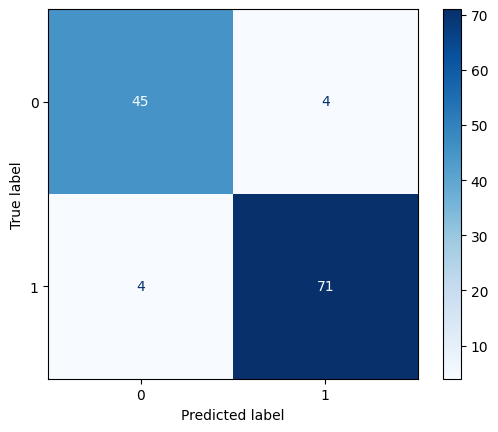

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 20, 'min_samples_split': 15, 'n_estimators': 25}
 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-36-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spam percentage = 0.7080369843527738
train accuracy = 0.9914651493598862
test accuracy = 0.8870967741935484
Recall = 0.88
Precision = 0.9295774647887324
F1 score = 0.9041095890410958
F2 score = 0.889487870619946
MCC = 0.768808850882612
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        49
           1       0.93      0.88      0.90        75

    accuracy                           0.89       124
   macro avg       0.88      0.89      0.88       124
weighted avg       0.89      0.89      0.89       124



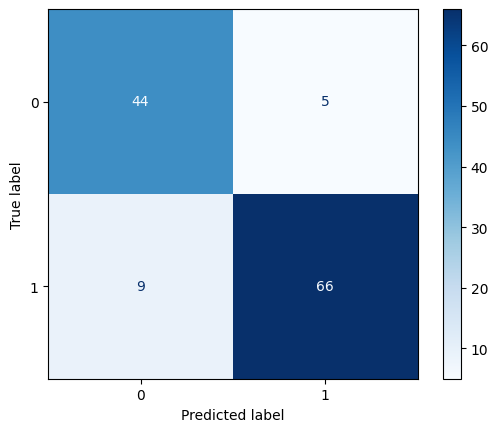

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 15, 'n_estimators': 25}
 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-36-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spam percentage = 0.6362428001772265
train accuracy = 0.9911386796632699
test accuracy = 0.8951612903225806
Recall = 0.8933333333333333
Precision = 0.9305555555555556
F1 score = 0.9115646258503401
F2 score = 0.9005376344086021
MCC = 0.7839670512601153
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        49
           1       0.93      0.89      0.91        75

    accuracy                           0.90       124
   macro avg       0.89      0.90      0.89       124
weighted avg       0.90      0.90      0.90       124



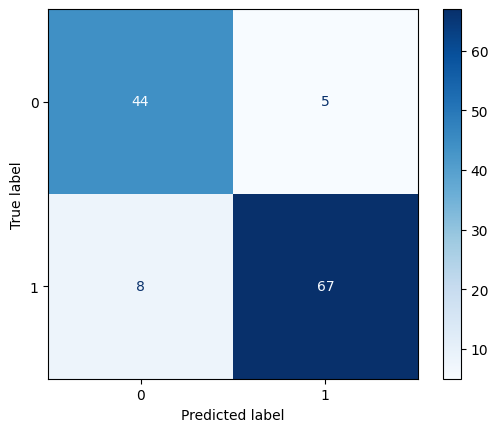

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 15, 'n_estimators': 25}
 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-36-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spam percentage = 0.5476584022038568
train accuracy = 0.9928374655647383
test accuracy = 0.8870967741935484
Recall = 0.84
Precision = 0.9692307692307692
F1 score = 0.9
F2 score = 0.8630136986301369
MCC = 0.7823346948086399
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        49
           1       0.97      0.84      0.90        75

    accuracy                           0.89       124
   macro avg       0.88      0.90      0.89       124
weighted avg       0.90      0.89      0.89       124



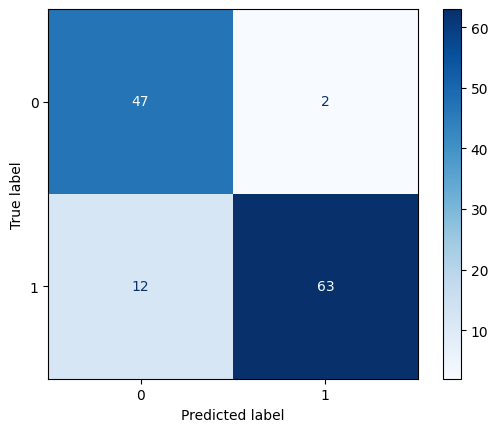

{'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 20, 'n_estimators': 25}
 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-36-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spam percentage = 0.43767123287671234
train accuracy = 0.9972602739726028
test accuracy = 0.8709677419354839
Recall = 0.8
Precision = 0.9836065573770492
F1 score = 0.8823529411764706
F2 score = 0.8310249307479226
MCC = 0.762361160281275
              precision    recall  f1-score   support

           0       0.76      0.98      0.86        49
           1       0.98      0.80      0.88        75

    accuracy                           0.87       124
   macro avg       0.87      0.89      0.87       124
weighted avg       0.90      0.87      0.87       124



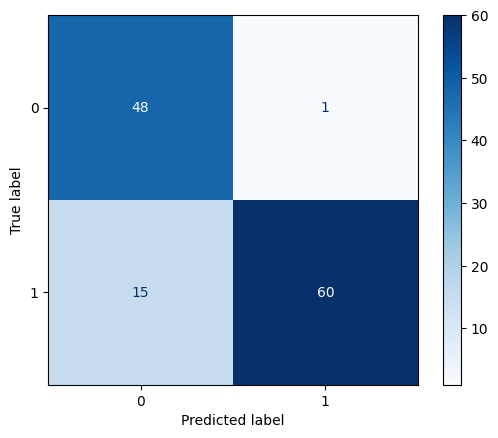

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 15, 'n_estimators': 25}
 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-36-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Spam percentage = 0.35252365930599366
train accuracy = 0.9968454258675079
test accuracy = 0.7983870967741935
Recall = 0.6666666666666666
Precision = 1.0
F1 score = 0.8
F2 score = 0.7142857142857142
MCC = 0.6644105970267493
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        49
           1       1.00      0.67      0.80        75

    accuracy                           0.80       124
   macro avg       0.83      0.83      0.80       124
weighted avg       0.87      0.80      0.80       124



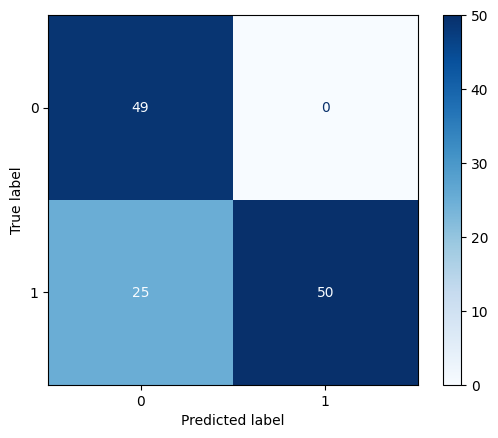

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 25, 'n_estimators': 20}


In [ ]:
word_sim_range = [.65, .675, .7, .725, .75, .775]

RF_sim_percentage_f1score = {}
RF_sim_percentage_f2score = {}

for value in word_sim_range:
  all_similar_words = {}
  my_augmented_dataset =  my_augmentation(train_data, lable=1, word_sim_threshold=value, sent_sim_threshold=.8)
  my_aug_X =  np.stack(np.array([get_text_vec(text) for text in my_augmented_dataset['text'].to_numpy()]))
  my_aug_y = my_augmented_dataset['label'].to_numpy()
  print('Spam percentage = {}'.format(np.count_nonzero(my_aug_y) / len(my_aug_y)))
  RF_sim_percentage_f1score[value], RF_sim_percentage_f2score[value] = train(1, my_aug_X, my_aug_y, X_test, y_test, evaluation_metrics_aug)

In [ ]:
all_similar_words = {}
augmented_dataset = my_augmentation(train_data, lable=1, word_sim_threshold=.65, sent_sim_threshold=.8)

 0 %
 16 %
 33 %
 50 %
 67 %
 84 %


<ipython-input-21-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
2049,records indicate u maybe entitled 5000 pounds ...,1
99,thought slide,0
1761,urgent mobile number awarded £2000 prize guara...,1
2776,phony £350 accolade todays voda numbers ending...,1
2595,i_wouldnt believe true incredible txts reply g...,1
...,...,...
270,alex says hes ok ok,0
924,im bus love,0
1300,garden ready summer free selection summer cfl_...,1
599,im viveki got number,0


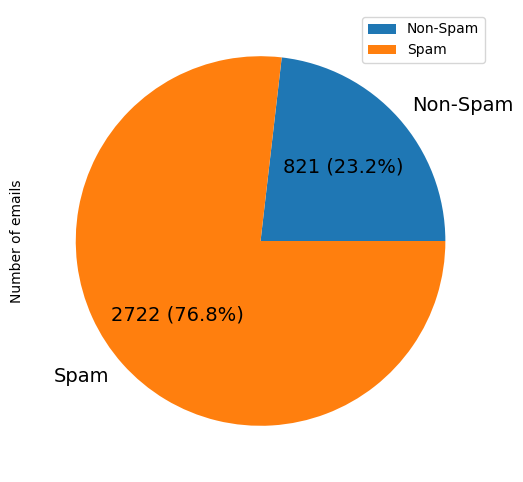

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(text) for text in augmented_dataset['text'].to_numpy()]))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
aug_X_train.shape

(3543, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(3543,)

## Random forest

train accuracy = 0.9895568727067457
test accuracy = 0.9112903225806451
Recall = 0.9466666666666667
Precision = 0.9102564102564102
F1 score = 0.9281045751633987
F2 score = 0.9391534391534391
MCC = 0.8134963376325113
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        49
           1       0.91      0.95      0.93        75

    accuracy                           0.91       124
   macro avg       0.91      0.90      0.91       124
weighted avg       0.91      0.91      0.91       124



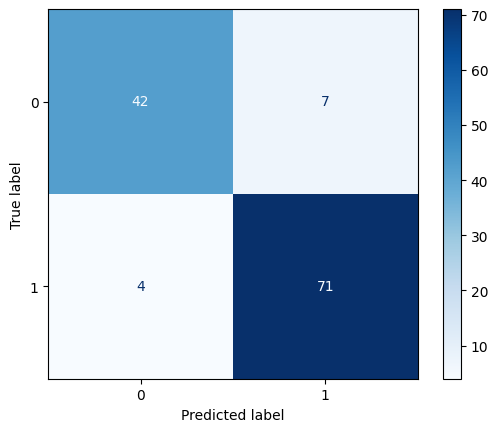

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 20, 'min_samples_split': 20, 'n_estimators': 25}


(0.9281045751633987, 0.9391534391534391)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TDAS_RF')

# SVM

train accuracy = 0.9985887665819927
test accuracy = 0.9112903225806451
Recall = 0.88
Precision = 0.9705882352941176
F1 score = 0.9230769230769231
F2 score = 0.8967391304347825
MCC = 0.824398566262439
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        49
           1       0.97      0.88      0.92        75

    accuracy                           0.91       124
   macro avg       0.90      0.92      0.91       124
weighted avg       0.92      0.91      0.91       124



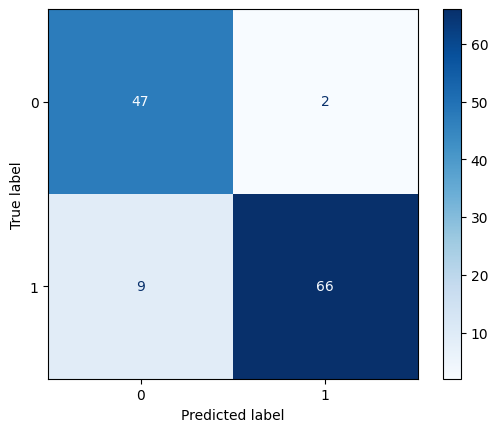

{'degree': 2, 'kernel': 'rbf'}


(0.9230769230769231, 0.8967391304347825)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TDAS_SVM')

#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold
seed = 221
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
text_words_lengths = [len(raw_train_data.loc[i]['text'].split()) for i in raw_train_data.index ]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))

In [ ]:
def create_blstm_model(sent_length, words_mean, train_texts):

  text_vec = layers.TextVectorization( 
    max_tokens=sent_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=words_mean
  )

  text_vec.adapt(train_texts)

  embedding_layer = layers.Embedding(
    input_dim=sent_length,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=words_mean
  )

  input_layer = layers.Input(shape=(1,), dtype=tf.string) 

  vec_layer = text_vec(input_layer)
  embedding_layer_model = embedding_layer(vec_layer) 

  bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer = L1L2(l1=0.01, l2=0.0)))(embedding_layer_model) 

  flatten = layers.Flatten()(bi_lstm) 
  dropout = layers.Dropout(.1)(flatten) 

  x = layers.Dense(32, activation='relu')(dropout) 

  output_layer = layers.Dense(1, activation='sigmoid')(x) 

  blstm_model = keras.Model(input_layer, output_layer) 

  blstm_model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])  
  
  return blstm_model

# Cross Validation

In [ ]:
def cv_blstm(sent_length, words_mean):

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(sent_length, words_mean, train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))

    f1_sc = f1_score(test_labels, y_pred)
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='binary')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred)
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm(total_length, text_words_mean)

Fold 0
Epoch 1/10
200/200 [==============================] - 23s 63ms/step - loss: 9.0655 - accuracy: 0.9620 - val_loss: 0.2500 - val_accuracy: 0.9915
Epoch 2/10
200/200 [==============================] - 3s 17ms/step - loss: 0.1365 - accuracy: 0.9969 - val_loss: 0.1740 - val_accuracy: 0.9831
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1037 - accuracy: 0.9984 - val_loss: 0.0933 - val_accuracy: 0.9972
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1284 - accuracy: 0.9984 - val_loss: 0.1269 - val_accuracy: 0.9972
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0929 - accuracy: 1.0000 - val_loss: 0.0880 - val_accuracy: 0.9972
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0778 - accuracy: 1.0000 - val_loss: 0.0852 - val_accuracy: 0.9944
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1360 - accuracy: 0.9994 - val_loss: 0.2422 - val_accuracy: 0

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,1.0,0.99635,0.998172,0.999268
1,1.0,0.978495,0.98913,0.995624
2,1.0,0.996337,0.998165,0.999265
3,1.0,0.996337,0.998165,0.999265
4,1.0,0.996337,0.998165,0.999265
5,0.996324,1.0,0.998158,0.997057
6,1.0,0.996337,0.998165,0.999265
7,1.0,0.989091,0.994516,0.997799
8,1.0,0.981949,0.990893,0.996337
9,1.0,0.992701,0.996337,0.998532


In [ ]:
cv_results.mean()

Recall       0.999632
Precision    0.992393
F1 score     0.995987
F2 score     0.998168
dtype: float64

In [ ]:
def train_blstm(sent_length, words_mean, train_texts, train_labels):

  blstm_model = create_blstm_model(sent_length, words_mean, train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(X_test, y_test))
  
  blstm_model.evaluate(X_test, y_test)
  y_pred = np.round(blstm_model.predict(X_test))

  f1_sc = f1_score(y_test, y_pred)
  f2score = fbeta_score(y_test, y_pred, beta=2, average='binary')
  mcc = matthews_corrcoef(y_test, y_pred)


  print("test accuracy = " + str(accuracy_score(y_test, y_pred)))
  print("Recall = {}".format(recall_score(y_test, y_pred)))
  print("Precision = {}".format(precision_score(y_test, y_pred)))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print("MCC = {}".format(mcc))
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc


In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(2376, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(2376, 1)

In [ ]:
train_blstm(total_length, text_words_mean, aug_X_train, aug_y_train)

 0 %
 16 %
 33 %
 50 %
 67 %
 84 %
Spam percentage = 0.7080369843527738


<ipython-input-44-3324af94901a>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


Epoch 1/10
561/562 [============================>.] - ETA: 0s - loss: 3.3609 - accuracy: 0.9647

562/562 [==============================] - 44s 67ms/step - loss: 3.3551 - accuracy: 0.9647 - val_loss: 0.6002 - val_accuracy: 0.8629
Epoch 2/10
562/562 [==============================] - 29s 51ms/step - loss: 0.1771 - accuracy: 0.9934
Epoch 3/10
562/562 [==============================] - 28s 50ms/step - loss: 0.1136 - accuracy: 0.9975
Epoch 4/10
562/562 [==============================] - 29s 52ms/step - loss: 0.0982 - accuracy: 0.9988
Epoch 5/10
562/562 [==============================] - 29s 51ms/step - loss: 0.1780 - accuracy: 0.9970
Epoch 6/10
  9/562 [..............................] - ETA: 26s - loss: 0.1165 - accuracy: 1.0000

4/4 [==============================] - 1s 7ms/step
test accuracy = 0.9193548387096774
Recall = 0.9066666666666666
Precision = 0.9577464788732394
F1 score = 0.9315068493150686
F2 score = 0.9164420485175201
MCC = 0.8354981111200683
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        49
           1       0.96      0.91      0.93        75

    accuracy                           0.92       124
   macro avg       0.91      0.92      0.92       124
weighted avg       0.92      0.92      0.92       124



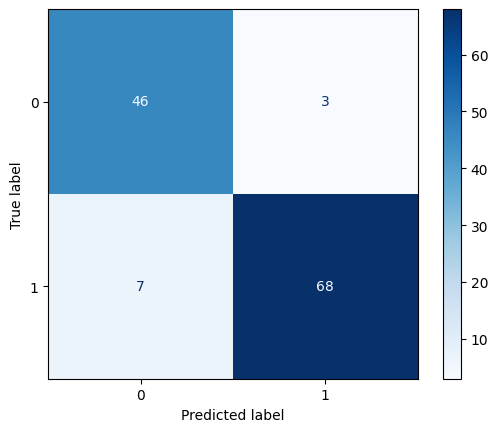

0.9315068493150686

In [ ]:
all_similar_words = {}
my_augmented_dataset =  my_augmentation(train_data, lable=1, word_sim_threshold=.675, sent_sim_threshold=.8)
my_aug_X = my_augmented_dataset['text'].to_numpy()
my_aug_y = my_augmented_dataset['label'].to_numpy()
print('Spam percentage = {}'.format(np.count_nonzero(my_aug_y) / len(my_aug_y)))
train_blstm(total_length, text_words_mean, my_aug_X, my_aug_y)